In [41]:
import openai
import requests
import ast
import time
import json
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor
import warnings

In [42]:
# ignore warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# image to be analysed

image_path = "../Scale_of_Remote-sensing_Images/demo_image/demo_1.png"

In [ ]:
# N.B. This reference_object list should be expanded and improved to include more objects and their sizes

reference_objects = [
    {"name": "car", "width_m": 1.8, "height_m": 4.5}, # car
    {"name": "bus", "width_m": 2.55, "height_m": 12.0},  # bus
    {"name": "truck", "width_m": 2.5, "height_m": 18.0}  # truck
]

reference_objects_list = [obj["name"] for obj in reference_objects]

In [ ]:
# Set up AOD API

AOD_url = "https://api.landing.ai/v1/tools/agentic-object-detection"
AOD_files = {"image": open(image_path, "rb")}

def send_AOD_request(image_path, object_prompt, AOD_url):
    with open(image_path, "rb") as image_file:
        files = {"image": image_file}
        data = {"prompts": f"{{{object_prompt}}}", "model": "agentic"}
        headers = {"Authorization": "Basic {'bnQ2aW9rMmJpN2N1bGQwNjhsbTljOkg3ZmFtcHY1dDc4TTVWS3FxZVprNzFYTEhzN3NSTlJD'}"}

        response = requests.post(AOD_url, files=files, data=data, headers=headers)

    return response.json()

In [34]:
# Use AOD to detect reference objects in the image
AOD_results = {}


for obj in reference_objects_list:
    print(f"detecting:{obj}")
    
    result = send_AOD_request(image_path, obj, AOD_url)

    # Check if the object was detected
    if result and "data" in result and result["data"] and result["data"][0]:
        AOD_results[obj] = result  

    time.sleep(5)  # avoid rate limiting of the API

print(AOD_results)

detecting:car
detecting:bus
detecting:truck
{'car': {'data': [[{'label': '{car}', 'score': 1.0, 'bounding_box': [1089.0, 403.0, 1154.0, 486.0]}]]}}


In [58]:
# Set up SAM2 model

class SAM2:
    """ SAM2 class for object segmentation and measurement """
    
    def __init__(self, checkpoint_path, model_type="vit_h"):
        """
        Initialize SAM2 model
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
        self.sam.to(device=self.device)
        self.predictor = SamPredictor(self.sam)
    
    def load_image(self, image_path):
        """ Load image and convert to RGB format """
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Error: Image not found at {image_path}")
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    def set_image(self, image):
        """ Set image for prediction """
        self.predictor.set_image(image)
    
    def predict_mask(self, x1, y1, x2, y2):
        """ Segment object and return mask """
        input_point = np.array([[(x1 + x2) // 2, (y1 + y2) // 2]])  # Find center of bounding box
        input_label = np.array([1])

        # Segment object
        masks, scores, logits = self.predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True
        )

        if masks is None or len(masks) == 0:
            raise ValueError("Error: No masks were generated. Check your input bounding box or model.")

        return masks[np.argmax(scores)]  # Return mask with highest score

    def get_bounding_box(self, mask):
        """ Obtain smallest bounding box from mask """
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("Warning: No contours found in mask.")
            return None, None

        largest_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        return np.int0(box), rect  # Convert coordinates to integer values

    def visualize_segmentation(self, image, mask, box, rect):
        """ Display image with segmentation mask and bounding box """
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        
        # Show mask
        mask_image = (mask > 0).astype(np.uint8) * 255  # Ensure binary mask
        plt.imshow(mask_image, alpha=0.6, cmap="jet")

        # Draw bounding box
        if box is not None:
            cv2.drawContours(image, [box], 0, (0, 255, 0), 2)
            width, height = rect[1]
            plt.text(rect[0][0], rect[0][1], f'W: {int(width)}px H: {int(height)}px',
                     color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

        plt.axis("off")
        plt.show()

    def segment_and_measure(self, image_path, x1, y1, x2, y2):
        """ Segment object and measure width """
        try:
            image = self.load_image(image_path)
            self.set_image(image)
            
            mask = self.predict_mask(x1, y1, x2, y2)
            
            box, rect = self.get_bounding_box(mask)
            
            self.visualize_segmentation(image, mask, box, rect)
            
            if rect:
                return min(rect[1])  # Take minimum of width and height as width
            return None
        
        except Exception as e:
            print(f"Error in segmentation: {e}")
            return None
        
    def compute_mask_pixel(self, mask):
        """ calculate the number of pixels in the mask """
        pixel_count = np.sum(mask > 0) 
        return pixel_count 

sam2 = SAM2(checkpoint_path="../Scale_of_Remote-sensing_Images/models/sam_vit_h_4b8939.pth")

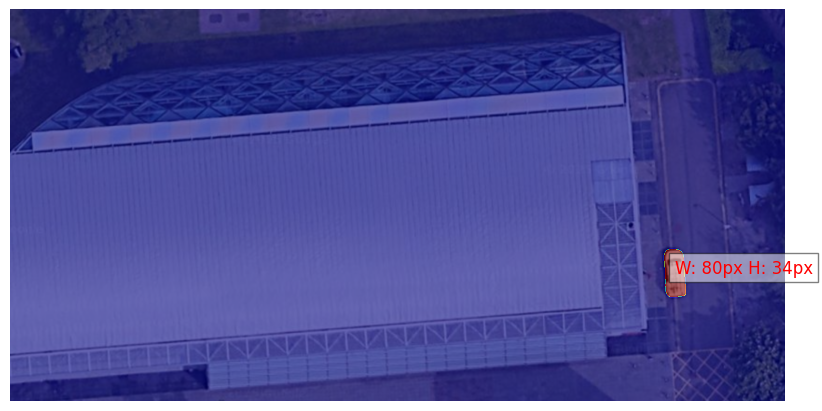

{'car': [34.10266876220703]}


In [59]:
segmentation_results = {}

# Segment and measure objects' pixel size
for obj_name, obj_data in AOD_results.items():
    
    # read the bounding box coordinates
    bboxes = obj_data["data"][0]  # values from AOD_results data[0]
    
    for i, bbox_info in enumerate(bboxes):
        x1, y1, x2, y2 = bbox_info["bounding_box"]
        object_width = sam2.segment_and_measure(image_path, x1, y1, x2, y2)
        segmentation_results.setdefault(obj_name, []).append(object_width)

print(segmentation_results)

In [60]:
# determine the scale of the image

def calculate_scale(segmentation_results, reference_objects):

    scale_m_per_pixel = {}
    scale_values = []

    # scale values obtained from each reference object to get average
    for obj in segmentation_results.keys():

        # get the real width of the object
        real_width_m = next((item["width_m"] for item in reference_objects if item["name"] == obj), None)

        # calculate the average pixel width of the object
        avg_pixel_width = sum(segmentation_results[obj]) / len(segmentation_results[obj])

        # calculate the scale
        scale = real_width_m / avg_pixel_width
        scale_m_per_pixel[obj] = scale
        scale_values.append(scale)

    # find the average scale to minimize error
    average_scale = sum(scale_values) / len(scale_values) if scale_values else None

    print(f"Average Scale: {average_scale:.5f} m/pixel")

    return average_scale


average_scale = calculate_scale(segmentation_results, reference_objects)

Average Scale: 0.05278 m/pixel


后期我们可以做一个user interface，可以让用户用鼠标选择图中想要知道面积的物体，然后计算面积

area of selected object: 1518.79 m²


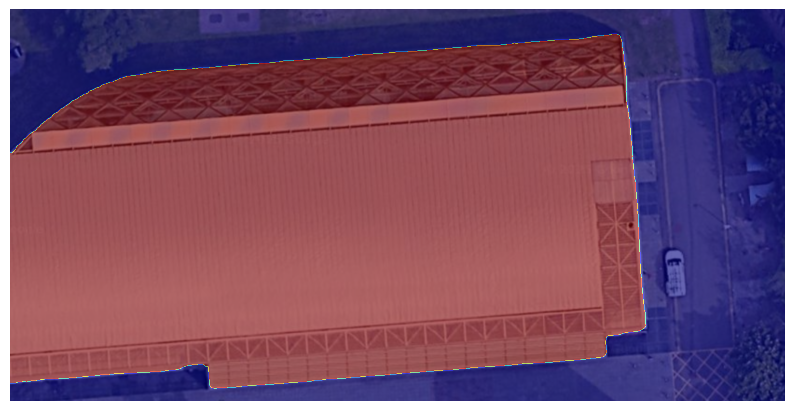

In [62]:
# STEP 5: Use the scale to calculate the area of a specific object

# locate the object of interest
object_name = "building"
response = send_AOD_request(image_path, object_name, AOD_url)
first_bbox = response["data"][0][0]["bounding_box"]
x1, y1, x2, y2 = first_bbox

# segment the object
mask = sam2.predict_mask(x1, y1, x2, y2)

# calculate the area of the object
selected_object_area = sam2.compute_mask_pixel(mask) * (average_scale ** 2)
print(f"area of selected object: {selected_object_area:.2f} m²")

# visualize the segmentation
sam2.visualize_segmentation(sam2.load_image(image_path), mask, None, None)
